<a href="https://colab.research.google.com/github/hamedebrahimi68/financial_markets_predictoin/blob/master/v3_lstm_cnn_multiprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D , MaxPooling1D, Flatten, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from datetime import datetime, timedelta

In [ ]:
def get_bitcoin_data():
    btc = yf.Ticker("BTC-USD")
    data = btc.history(period="2y", interval="1h")
    return data['Close']

In [ ]:
def prepare_data(data, time_steps=1):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:i+time_steps])
        y.append(scaled_data[i+time_steps])

    X, y = np.array(X), np.array(y)

    # تقسیم داده‌ها به train و test
    train_size = int(len(X) * 0.8)
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]

    return X_train, X_test, y_train, y_test, scaler

In [ ]:

def create_model(time_steps):
    # Define inputs
    input_layer = Input(shape=(time_steps, 1))

    # CNN path
    cnn = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Flatten()(cnn)

    # LSTM path
    lstm = LSTM(64, return_sequences=True)(input_layer)
    lstm = Dropout(0.1)(lstm)
    lstm = LSTM(32, return_sequences=False)(lstm)
    lstm = Dropout(0.1)(lstm)
    lstm = BatchNormalization()(lstm)

    # Combine CNN and LSTM paths
    combined = concatenate([cnn, lstm])

    # Dense layers
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.2)(x)
    output = Dense(1)(x)

    # Create and compile model
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

دریافت داده‌های بیت‌کوین...
آموزش مدل هیبریدی CNN-LSTM...
Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0186 - mae: 0.0807 - val_loss: 0.2085 - val_mae: 0.4550
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0015 - mae: 0.0265 - val_loss: 0.1287 - val_mae: 0.3571
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0013 - mae: 0.0249 - val_loss: 0.0614 - val_mae: 0.2466
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.7356e-04 - mae: 0.0203 - val_loss: 0.0430 - val_mae: 0.2064
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 8.7537e-04 - mae: 0.0193 - val_loss: 0.0181 - val_mae: 0.1338
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.7288e-04 - mae: 0.0182 - val_loss: 0.0070 - val_mae: 0.0828
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.4927e-04 - mae: 0.0181 - val_loss: 0.0049 - val_mae: 0.0687
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 8.0665e-04 - mae: 0.0187 - val_

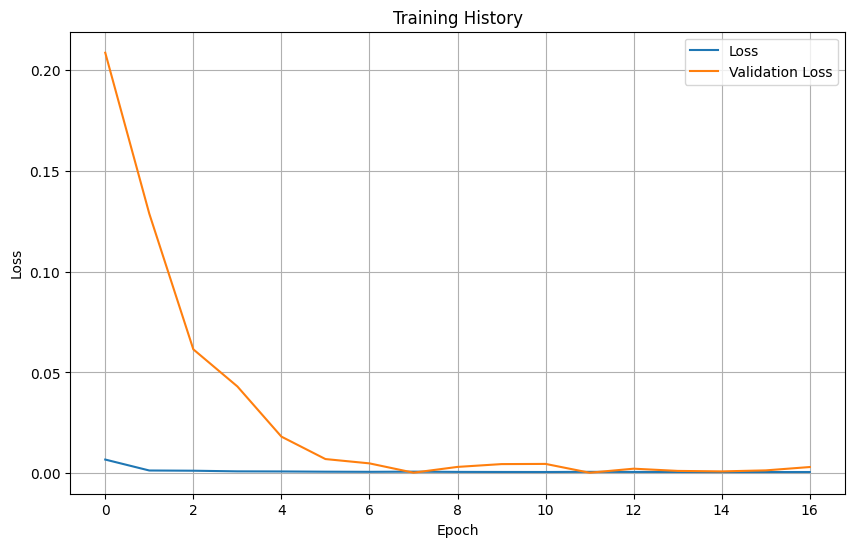

<ipython-input-5-3aeb78871b07>:66: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(


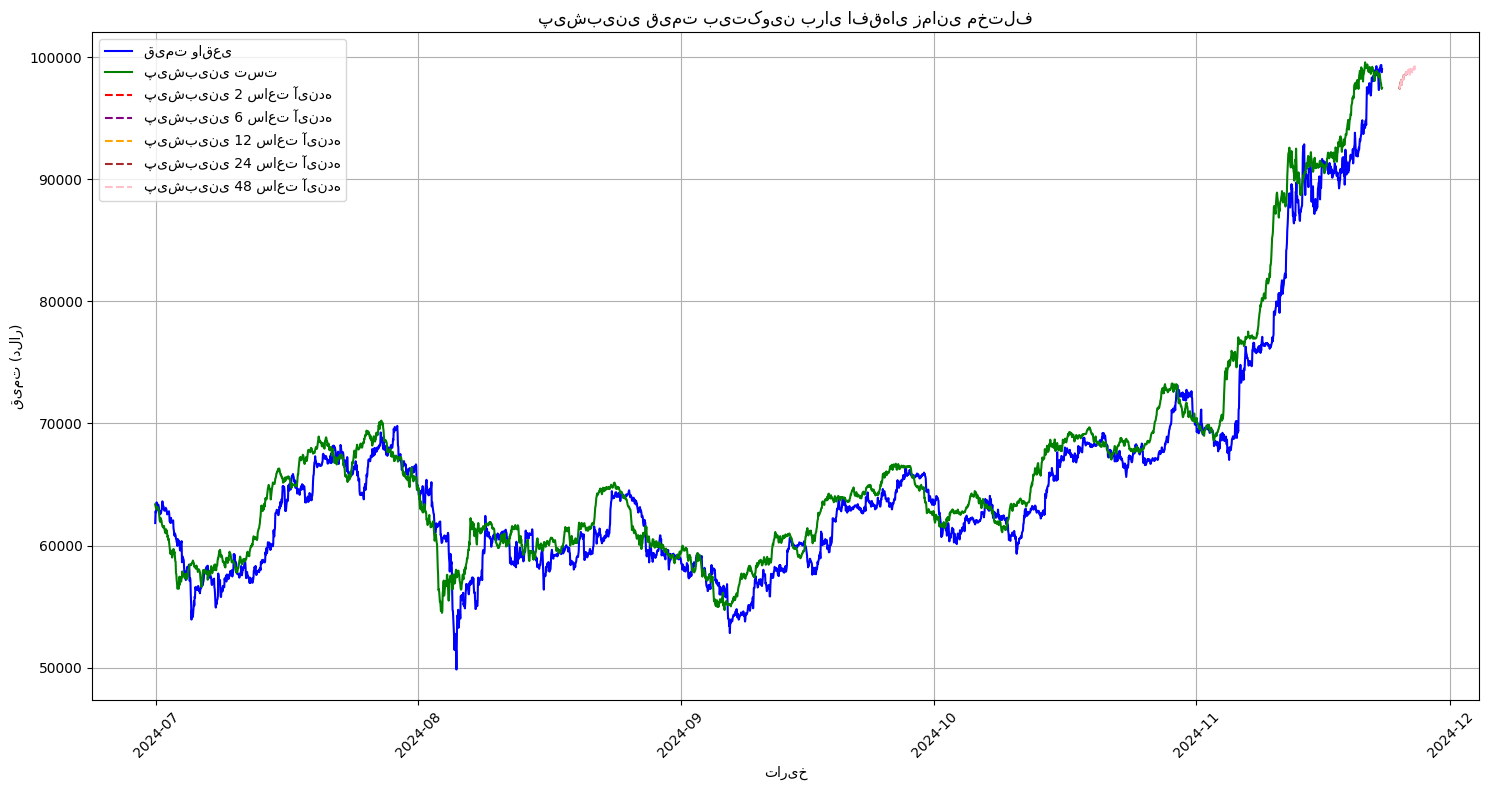

In [ ]:
def predict_multiple_horizons(model, last_sequence, scaler, horizons):
    """
    پیش‌بینی قیمت برای چندین افق زمانی مختلف

    Args:
        model: مدل آموزش دیده
        last_sequence: آخرین توالی داده‌ها
        scaler: scaler برای تبدیل معکوس داده‌ها
        horizons: لیستی از ساعت‌های مورد نظر برای پیش‌بینی
    """
    predictions = {}
    current_sequence = last_sequence.copy()
    max_horizon = max(horizons)

    # پیش‌بینی برای حداکثر افق زمانی
    all_predictions = []
    for _ in range(max_horizon):
        predicted_scaled = model.predict(current_sequence)
        all_predictions.append(predicted_scaled[0][0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[0][-1] = predicted_scaled

    # جمع‌آوری پیش‌بینی‌ها برای هر افق زمانی
    for horizon in horizons:
        horizon_predictions = all_predictions[:horizon]
        predictions[horizon] = scaler.inverse_transform(
            np.array(horizon_predictions).reshape(-1, 1)
        )

    return predictions

def plot_training_history(history):
    """
    رسم نمودار تاریخچه آموزش مدل
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_multiple_predictions(original_data, predictions, train_pred, test_pred, train_size):
    """
    رسم نمودار پیش‌بینی‌های چندگانه
    """
    plt.figure(figsize=(15, 8))

    # رسم داده‌های واقعی
    plt.plot(original_data.index[train_size:train_size + len(test_pred)],
             original_data[train_size:train_size + len(test_pred)],
             label='قیمت واقعی', color='blue')

    # رسم پیش‌بینی‌های تست
    plt.plot(original_data.index[train_size:train_size + len(test_pred)],
             test_pred, label='پیش‌بینی تست', color='green')

    # رنگ‌های مختلف برای افق‌های زمانی مختلف
    colors = ['red', 'purple', 'orange', 'brown', 'pink']

    # رسم پیش‌بینی‌های آینده برای هر افق زمانی
    for (horizon, pred), color in zip(predictions.items(), colors):
        future_dates = pd.date_range(
            start=original_data.index[-1],
            periods=len(pred)+1,
            freq='H'
        )[1:]
        plt.plot(future_dates, pred,
                label=f'پیش‌بینی {horizon} ساعت آینده',
                color=color, linestyle='--')

    plt.title('پیش‌بینی قیمت بیت‌کوین برای افق‌های زمانی مختلف')
    plt.xlabel('تاریخ')
    plt.ylabel('قیمت (دلار)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def print_predictions_summary(current_price, predictions):
    """
    چاپ خلاصه پیش‌بینی‌ها
    """
    print("\n=== خلاصه پیش‌بینی‌ها ===")
    print(f"قیمت فعلی: ${current_price:.2f}")

    for horizon, pred in predictions.items():
        final_price = pred[-1][0]
        change_percent = ((final_price - current_price) / current_price) * 100
        time_description = (
            "یک ماه" if horizon == 720 else
            "یک هفته" if horizon == 168 else
            f"{horizon} ساعت"
        )
        print(f"\nپیش‌بینی برای {time_description} آینده:")
        print(f"قیمت: ${final_price:.2f}")
        print(f"درصد تغییر: {change_percent:.2f}%")
        print(f"تغییر مطلق: ${(final_price - current_price):.2f}")

# کد اصلی برای اجرا
def main():
    # دریافت داده‌ها
    print("دریافت داده‌های بیت‌کوین...")
    bitcoin_data = get_bitcoin_data()

    # آماده‌سازی داده‌ها
    TIME_STEPS = 48
    X_train, X_test, y_train, y_test, scaler = prepare_data(bitcoin_data, TIME_STEPS)

    # ساخت و آموزش مدل
    print("آموزش مدل هیبریدی CNN-LSTM...")
    model = create_model(TIME_STEPS)

    # تنظیم Early Stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # آموزش مدل
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # پیش‌بینی روی داده‌های تست
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # تبدیل پیش‌بینی‌ها به مقیاس اصلی
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # پیش‌بینی برای افق‌های زمانی مختلف
    horizons = [2, 6, 12, 24, 48, 72, 168, 720]  # 12, 24h, 48h, 72h, 1 week, 1 month
    last_sequence = X_test[-1:]
    predictions = predict_multiple_horizons(model, last_sequence, scaler, horizons)

    # نمایش نتایج
    current_price = bitcoin_data.iloc[-1]
    print_predictions_summary(current_price, predictions)

    # رسم نمودارها
    plot_training_history(history)
    plot_multiple_predictions(bitcoin_data, predictions, train_predict, test_predict, len(train_predict))

if __name__ == "__main__":
    main()